In [41]:
%pip install pyarrow pandas matplotlib seaborn scikit-learn joblib

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [47]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error

# Q1

In [81]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')
print("Number of columns:", df.shape[1])
df.head()

Number of columns: 19


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

# Q2

In [83]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
print("Standard deviation of trips duration in January: %.2f" % df.duration.std())

Standard deviation of trips duration in January: 42.59


# Q3

In [84]:
total_rows = df.shape[0]
df = df[(df.duration >= 1) & (df.duration <= 60)]
rows = df.shape[0]

print(f"Fraction of recors left after outlier removal: {int((rows/total_rows)*100)}%")

Fraction of recors left after outlier removal: 98%


# Q4

In [85]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [86]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print("Dimensionality of the matrix: ", X_train.shape[1])

Dimensionality of the matrix:  515


# Q5

In [87]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print("Training RMSE: ", root_mean_squared_error(y_train, y_pred))

Training RMSE:  7.649261822035489


# Q6

In [89]:
df_val = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet')
df_val['duration'] = df_val.tpep_dropoff_datetime - df_val.tpep_pickup_datetime
df_val.duration = df_val.duration.apply(lambda x: x.total_seconds() / 60)

df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
y_val = df_val[target].values

y_pred = lr.predict(X_val)

print("Validation RMSE: ", root_mean_squared_error(y_val, y_pred))

Validation RMSE:  7.811821332387183


# Solution organized

In [98]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

def distribution_plot(true, pred):
    sns.histplot(pred, label='prediction', kde=True, stat="density")
    sns.histplot(true, label='actual', kde=True, stat='density')

    plt.legend()


In [93]:
df_train = read_dataframe('../data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

len(df_train), len(df_val)

(3009173, 2855951)

In [94]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [96]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [100]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print("Training RMSE: ", root_mean_squared_error(y_train, y_pred))

Training RMSE:  7.649261822035489


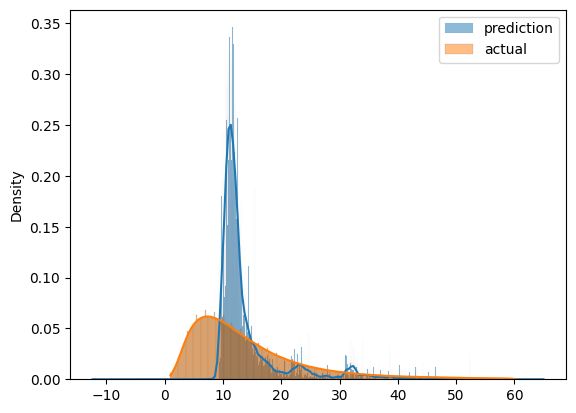

In [101]:
distribution_plot(y_train, y_pred)

In [102]:
y_pred = lr.predict(X_val)
print("Validation RMSE: ", root_mean_squared_error(y_val, y_pred))

Validation RMSE:  7.811821332387183


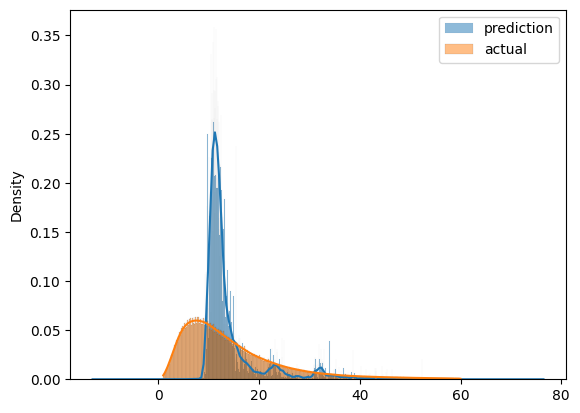

In [103]:
distribution_plot(y_val, y_pred)

In [104]:
with open('../models/lin_reg_01.bin', 'wb') as f_out:
    joblib.dump((dv, lr), f_out)